# A deep dive into timeseries forecasting

Starting from the results achieve yesterday, in this lab we will go through the optimization of forecasting model parameters and regressors:
1. Download data
2. Exploratory Data Analysis (EDA)
3. Add and explore extra regressors
4. What's about Covid-19
5. Explore correlation 
6. Forecasting models - Prophet

In [1]:
# *IMPORT LIBRARIES USED*

!pip install fbprophet
!pip install yfinance
from fbprophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

     |████████████████████████████████| 6.3MB 4.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=7328cd613f9007d43a604425f2172d92313fc33db682d53c73bd3104a5334cf1
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# 1. Download data 

Definition of an analysis starting and ending period

In [2]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2021-05-24')

Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [3]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X', 'CPI']

Download the previous tickers only for Close prices

In [6]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Scaling the Prices by Percentage Change, in order to remove differences between Prices, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate.

In [7]:
# New Dataframe cleaned
forex_df

eurusd_close  gbpusd_close  ...  audusd_close  cpi_close
Date                                    ...                         
2010-01-01      1.438994      1.613294  ...      0.898473        NaN
2010-01-04      1.442398      1.611370  ...      0.912492  25.100000
2010-01-05      1.436596      1.599079  ...      0.911826  25.120001
2010-01-06      1.440403      1.602384  ...      0.920471  25.139999
2010-01-07      1.431803      1.593397  ...      0.917768  25.110001
...                  ...           ...  ...           ...        ...
2021-05-20      1.217285      1.410616  ...      0.772030  27.320000
2021-05-21      1.222539      1.418560  ...      0.777000  27.309999
2021-05-24      1.218324      1.414287  ...      0.773000  27.340000
2021-05-25      1.221464      1.415609  ...      0.775080  27.350000
2021-05-26      1.219661      1.411751  ...      0.774653        NaN

[2974 rows x 8 columns]

# Add other regressor

What's the influence of external forces on FOREX?

We have dowload different timeseries that could have influenced the FOREX. It's clear that the use of these regressors to improve the forecasting performances increases the complexity of the model.

i.e. Let's say that we would like to forecast FOREX in the horizon May 2021 - Jan 2022. The values of extra regressor should be known, which means that other ML models should be use to forecast for example US GDP

Here we studied the effect of GDP, inflation and consumer price index on FOREX. 
Raw data were downloaded from https://fred.stlouisfed.org/

In [37]:
def get_new_data():
    url_extra = 'https://drive.google.com/file/d/1CT91MvzT2-WLK6rTdDu4-vBdj0kyfDP5/view?usp=sharing'
    url_covid = 'https://drive.google.com/file/d/1ZlwZtSdtxlTlP2RUZtYjqpVSiaXMEzXO/view?usp=sharing'
    url_int_rate = 'https://drive.google.com/file/d/1KbYQh4fDbTfuJpSHjg36Yl2L-nhywpTK/view?usp=sharing'

 

    file_id = url_extra.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_extra = pd.read_csv(dwn_url, parse_dates=['DATE'])

 

    file_id = url_covid.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_covid = pd.read_csv(dwn_url, parse_dates=['date'])

    file_id = url_int_rate.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_int_rate = pd.read_csv(dwn_url, skiprows=4)

 

    return df_extra, df_covid, df_int_rate

In [38]:
extra_df, df_covid, df_int_rate = get_new_data()

In [39]:
df_int_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182 entries, 0 to 8181
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Period\Unit:            8182 non-null   object 
 1   [Percent ]              45 non-null     float64
 2   [Percent per annum ]    49 non-null     float64
 3   [Percent ].1            44 non-null     float64
 4   [Percent per annum ].1  49 non-null     float64
 5   [Percent ].2            42 non-null     float64
 6   [Percent per annum ].2  28 non-null     float64
 7   [Percent per annum ].3  21 non-null     object 
 8   [Percent ].3            8180 non-null   object 
 9   [Percent per annum ].4  8182 non-null   float64
 10  [Percent ].4            8180 non-null   object 
 11  [Percent per annum ].5  8182 non-null   float64
 12  [Percent per annum ].6  5151 non-null   float64
dtypes: float64(9), object(4)
memory usage: 831.1+ KB


In [40]:
df_int_rate.drop(df_int_rate.columns[1:8],axis=1)

Period\Unit: [Percent ].3  ...  [Percent per annum ].5 [Percent per annum ].6
0      2021-05-26      -0.1000  ...                    0.25                    0.0
1      2021-05-25      -0.1000  ...                    0.25                    0.0
2      2021-05-24      -0.1000  ...                    0.25                    0.0
3      2021-05-23      -0.1000  ...                    0.25                    0.0
4      2021-05-22      -0.1000  ...                    0.25                    0.0
...           ...          ...  ...                     ...                    ...
8177   1999-01-05       0.7500  ...                    3.25                    3.0
8178   1999-01-04       0.7500  ...                    3.25                    3.0
8179   1999-01-03          NaN  ...                    4.50                    3.0
8180   1999-01-02          NaN  ...                    4.50                    3.0
8181   1999-01-01            -  ...                    4.50                    3.0

[8182 rows x 6 columns]

In [36]:
df_int_rate

Period\Unit:  ... [Percent per annum ].6
0      2021-05-26  ...                    0.0
1      2021-05-25  ...                    0.0
2      2021-05-24  ...                    0.0
3      2021-05-23  ...                    0.0
4      2021-05-22  ...                    0.0
...           ...  ...                    ...
8177   1999-01-05  ...                    3.0
8178   1999-01-04  ...                    3.0
8179   1999-01-03  ...                    3.0
8180   1999-01-02  ...                    3.0
8181   1999-01-01  ...                    3.0

[8182 rows x 7 columns]

In [14]:
extra_df.set_index('DATE',inplace=True)

In [ ]:
# read extra regressors from csv. See raw data link to download them
#extra_df = pd.read_csv('extra_regressors.csv', parse_dates=['DATE']).set_index('DATE')

In [15]:
extra_df

CPIAUCSL        GDP  T10YIE
DATE                                   
1947-01-01    21.480    243.164     NaN
1947-01-02    21.480    243.164     NaN
1947-01-03    21.480    243.164     NaN
1947-01-04    21.480    243.164     NaN
1947-01-05    21.480    243.164     NaN
...              ...        ...     ...
2021-05-16   266.832  22048.894    2.51
2021-05-17   266.832  22048.894    2.54
2021-05-18   266.832  22048.894    2.52
2021-05-19   266.832  22048.894    2.48
2021-05-20   266.832  22048.894    2.41

[27169 rows x 3 columns]

In [17]:
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)

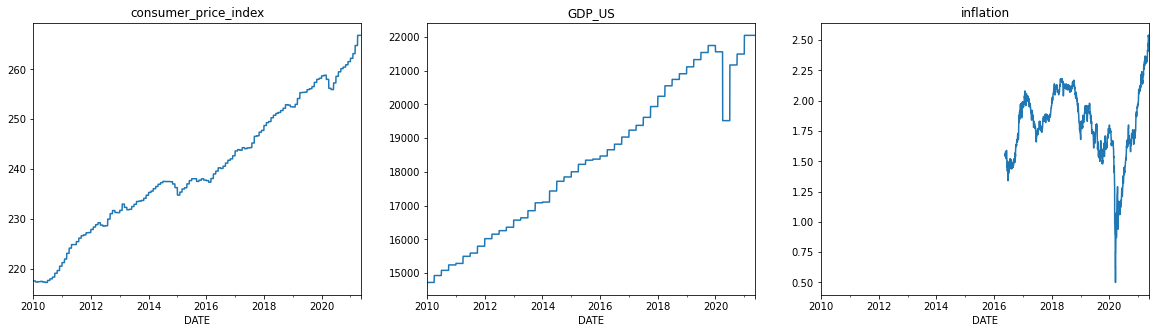

In [19]:
# plot timeseries
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(extra_df):
  extra_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

# What's about COVID-19

**Is the global vaccination race the new force in FX markets? – Special Report**

https://www.xm.com/is-the-global-vaccination-race-the-new-force-in-fx-markets-special-report-135646

2020 and 2021 have been affected by COVID-19 pandemic. We all know the effect of the pandemic on daily life and economics. Starting from the first days of 2021, vaccinations and growth perspective have influenced a slow restart of "normal" life and therefore of economy. 

Here we explore the effect of covid and vaccinations on FOREX.
Data were downloaded from https://github.com/owid/covid-19-data

In [ ]:
# load dataset of covid new cases
#df_covid= pd.read_csv('owid-covid-data.csv', parse_dates=['date'])
#df_covid.set_index('date', inplace=True)

In [ ]:
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})

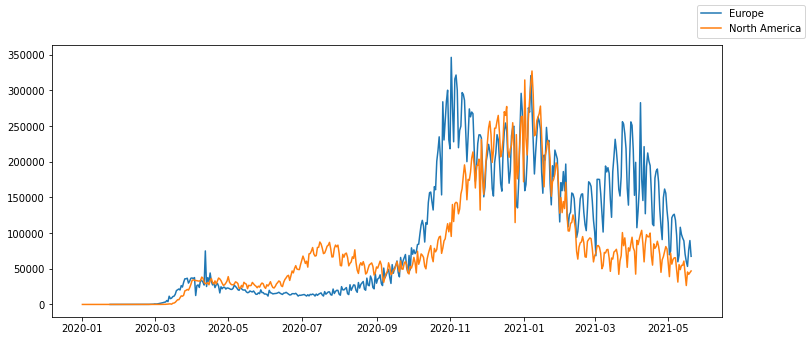

In [ ]:
# compare Europe and North America time series
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_covid_g.loc['Europe'], label='Europe')
ax.plot(df_covid_g.loc['North America'], label='North America')
fig.legend()

# Check time series correlation

Now we explore timeseries correlation

In [ ]:
# merge the data in a single dataframe to explore timeseries correlation
forex_df_reg = forex_df.merge(extra_df, left_index=True, right_index=True, how='left')

In [ ]:
forex_df_reg = forex_df_reg.merge(df_covid_g.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_index=True, right_index=True, how='left')
forex_df_reg = forex_df_reg.merge(df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_index=True, right_index=True, how='left')
forex_df_reg['covid_US'] = forex_df_reg['covid_US'].fillna(0)
forex_df_reg['covid_EU'] = forex_df_reg['covid_EU'].fillna(0)

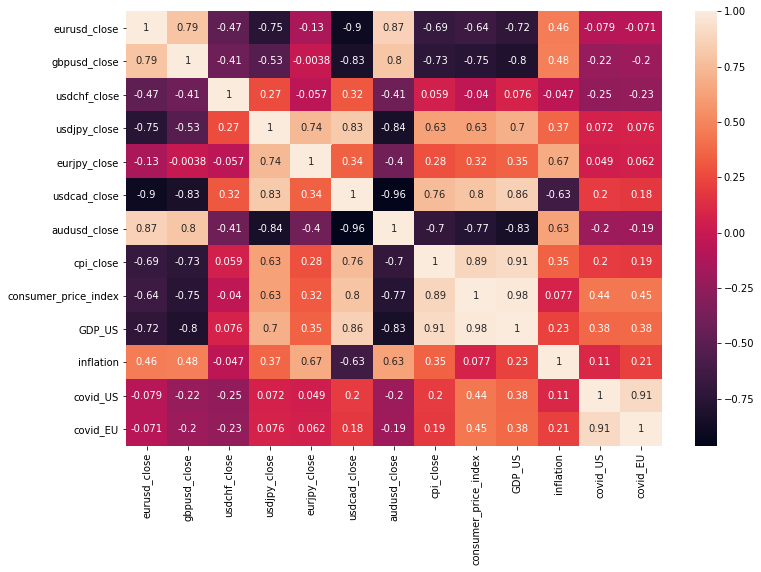

In [ ]:
# explore correlation
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(forex_df_reg.corr(), annot=True, ax=ax)

# 3. Forecasting Method - Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (Facebook-Prophet website: https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=Prophet%20is%20open%20source%20software,download%20on%20CRAN%20and%20PyPI.)

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to eurgbp_close) to df['y']
2. ALWAYS Reset the index of the series and rename the column with the date in df['ds']

In [ ]:
# In order to forecast the series we need to:
# 1)
forex_df_reg['ds'] = forex_df_reg.index
forex_df_reg['y'] = forex_df_reg['eurusd_close'].values
forex_df_reg = forex_df_reg.dropna()

forex_df_reg.tail()

eurusd_close  gbpusd_close  ...         ds         y
Date                                    ...                     
2021-05-14      1.207729      1.405086  ... 2021-05-14  1.207729
2021-05-17      1.215037      1.410179  ... 2021-05-17  1.215037
2021-05-18      1.215687      1.414867  ... 2021-05-18  1.215687
2021-05-19      1.222400      1.418802  ... 2021-05-19  1.222400
2021-05-20      1.217285      1.410616  ... 2021-05-20  1.217285

[5 rows x 15 columns]

In [ ]:
# define test and train window
train_window =  ['2010-01-03','2020-10-31']
test_window =  ['2020-11-01','2021-05-21']

In [ ]:
# create train and test dataset
train = forex_df_reg[train_window[0]:train_window[1]]
test = forex_df_reg[test_window[0]:test_window[1]]

In [ ]:
# define Prophet model with hyperparameters
m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)
# add custom seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor
extra_regressor = ['consumer_price_index','GDP_US','inflation', 'covid_US', 'covid_EU']
for reg in extra_regressor:
  m.add_regressor(name=reg, mode='additive')


In [ ]:
# train model
m.fit(train)

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# make future dataframe and predict
future = m.make_future_dataframe(test.shape[0], freq='B') # Explain B
forecast = m.predict(future.merge(forex_df_reg[extra_regressor], left_on='ds', right_index=True, how='left').fillna(method='pad'))

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_results.set_index('ds', inplace=True)

In [ ]:
future.merge(forex_df_reg[extra_regressor], left_on='ds', right_index=True, how='left').fillna(method='pad')

ds  consumer_price_index     GDP_US  inflation  covid_US  covid_EU
0    2016-05-20               239.557  18656.207       1.56       0.0       0.0
1    2016-05-23               239.557  18656.207       1.54       0.0       0.0
2    2016-05-24               239.557  18656.207       1.55       0.0       0.0
3    2016-05-25               239.557  18656.207       1.58       0.0       0.0
4    2016-05-26               239.557  18656.207       1.58       0.0       0.0
...         ...                   ...        ...        ...       ...       ...
1231 2021-05-06               266.832  22048.894       2.45   65359.0  126528.0
1232 2021-05-07               266.832  22048.894       2.49   65436.0  118314.0
1233 2021-05-10               266.832  22048.894       2.54   55867.0   69099.0
1234 2021-05-11               266.832  22048.894       2.53   48803.0  108217.0
1235 2021-05-12               266.832  22048.894       2.54   54844.0   98176.0

[1236 rows x 6 columns]

In [ ]:
final_df_results = pd.merge(test['eurusd_close'], forecast_results[['yhat']], left_index=True, right_index=True)

In [ ]:
final_df_results['eurusd_close']

2020-11-02    1.164212
2020-11-03    1.164280
2020-11-04    1.176221
2020-11-05    1.173268
2020-11-06    1.181754
                ...   
2021-05-06    1.200797
2021-05-07    1.206855
2021-05-10    1.217108
2021-05-11    1.214093
2021-05-12    1.214450
Name: eurusd_close, Length: 132, dtype: float64

## Model evaluation and scores

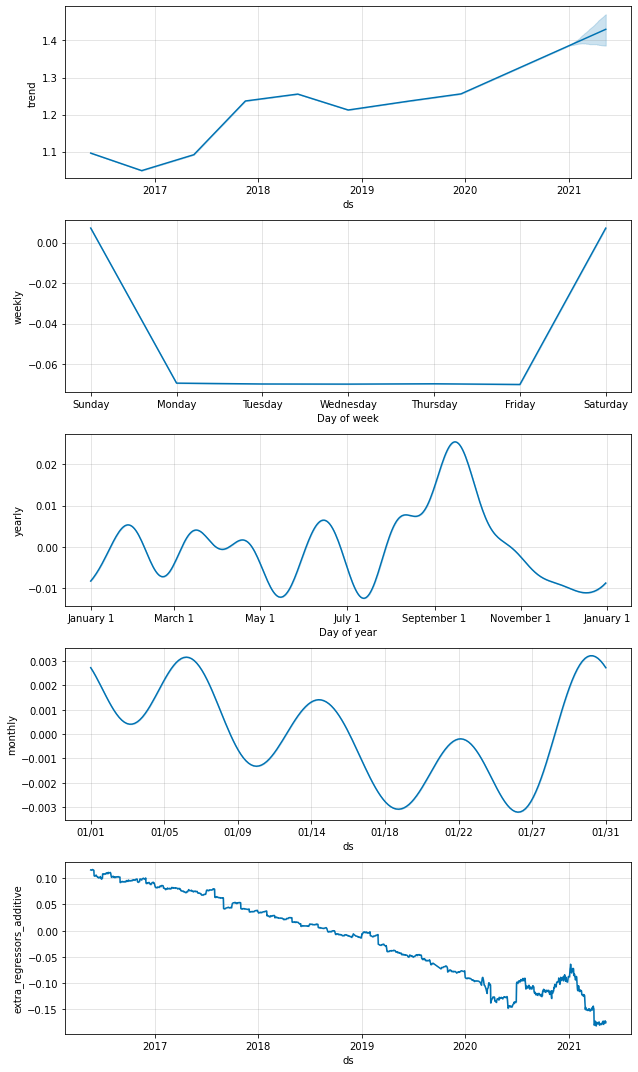

In [ ]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

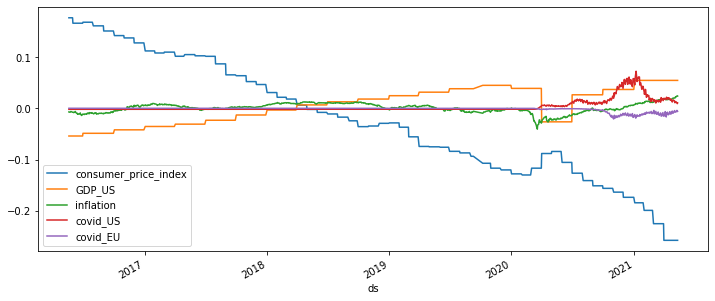

In [ ]:
# explore the role and weight of each extra regressor
fig, ax = plt.subplots(figsize=(12,5))
forecast.set_index('ds')[extra_regressor].plot(ax=ax)

In [ ]:
# explore results on the forecast window
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

In [ ]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


Mean MAE: 0.01
MAE%: 1.18%
RMSE: 0.02
Bias: -0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.01
50th percetile MAE: 0.01
75th percetile MAE: 0.02
95th percetile MAE: 0.03


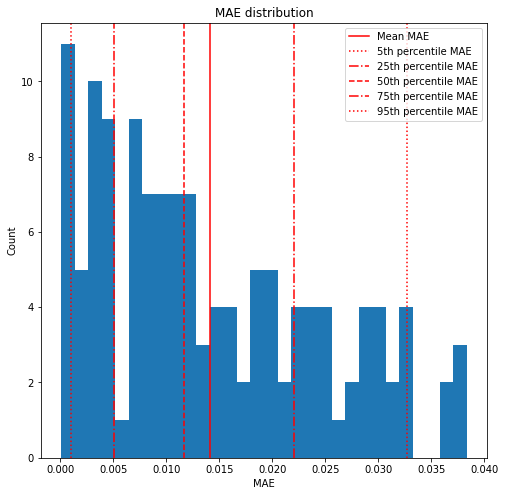

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)


# Take home messages

- ML alone cannot understand historical context --> "Human" driven model creation
- When modelling and testing the solution always ask yourself  "How I will use the model to improve my portfolio"

## Useful links

- Seasonality and Regressors - Example https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda
- Seasonality and Regressors - Documentation https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
-  FbProphet usecase - https://futurice.com/blog/business-forecasting-with-facebook-prophet